# Intro

This notebook is for measuring diodes. This was done by connecting different diode types to the four channels of the AD5522. Notice that LEDs are also a type of diode. I connected these devices to the AD5522:
* channel 0: 1N4007 diode, this is a classic 1kV diode often seen in bridge recrifiers
* channel 1: yellow LED
* channel 2: green LED
* channel 3: red LED  

The LEDs were taken from a '3mm Multi Color LED Kit' (511-8002-KIT-ND) from digi-key. The LEDs with the same color were mixed together so I don't know the exact type of LED I measured.

# Setup

In [9]:
from importlib import reload
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Reload already loaded modules
for m in ("AD5522_pi", "AD7685_pi", "AD5522dev_pi"):
    try:
        mod = sys.modules[m]
    except KeyError:
        pass
    else:
        reload(mod)
from AD5522dev_pi import AD5522dev
from AD5522_pi import MeasMode

In [10]:
board = AD5522dev(vref=5.0)

# Measurement

There are two main modes for using a SMU to do measurements on it's output port. First, and most used option, is to force a voltage and measure the resulting current. Second is the opposite, e.g. forcing current and measuring the resulting voltage.  
Below you find the procedure used to apply the two modes on the selected diodes.

## Forced current

In [8]:
def _block(): # Avoid generating global variables
    for ch in board.channels:
        ch.currentrange = "5µA"

    def _setandmeasure(iset):
        ivs = []
        for i, ch in enumerate(board.channels):
            board.measchannel = i
            ch.mode = MeasMode.FIMV
            ch.force = iset
            ivs.append(board.measure(count=10)[0])
            ch.mode = MeasMode.FIMI
            ivs.append(board.measure(count=10)[0])
        return ivs

    iset = np.arange(-0.05e-6, 5e-6, 0.01e-6)
    meas = np.array(tuple(_setandmeasure(i) for i in iset))

    for ch in board.channels:
        ch.mode = MeasMode.HIMV
        ch.force = 0.0
    
    return meas

meas_fi = _block()

## Forced voltage

In [20]:
def _block():
    for ch in board.channels:
        ch.currentrange = "5µA"

    def _setandmeasure(vset):
        ivs = []
        for i, ch in enumerate(board.channels):
            board.measchannel = i
            ch.mode = MeasMode.FVMV
            ch.force = vset
            ivs.append(board.measure(count=10)[0])
            ch.mode = MeasMode.FVMI
            ivs.append(board.measure(count=10)[0])
        return ivs

    vset = np.arange(-11, 11.1, 0.1)
    meas = np.array(tuple(_setandmeasure(v) for v in vset))

    for ch in board.channels:
        ch.mode = MeasMode.HVMV
        ch.force = 0.0

    return meas

meas_fv = _block()

# Results
In this chapter matplotlib is used to plot and analyze the results of our measurements.
## Forced current

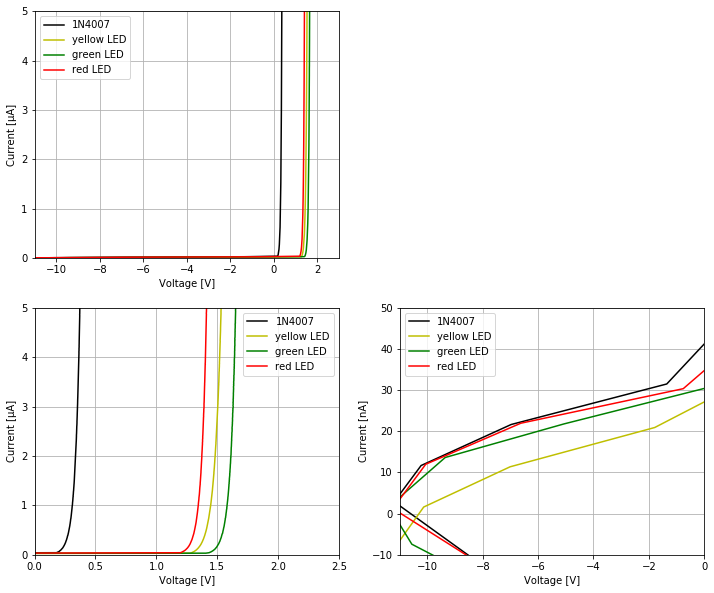

In [10]:
plt.figure(figsize=[12,10])

plt.subplot(2,2,1)

plt.plot(meas_fi[:,0], 1e6*meas_fi[:,1], 'k')
plt.plot(meas_fi[:,2], 1e6*meas_fi[:,3], 'y')
plt.plot(meas_fi[:,4], 1e6*meas_fi[:,5], 'g')
plt.plot(meas_fi[:,6], 1e6*meas_fi[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [µA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([-11, 3, -1e-4, 5])
plt.grid(True)


plt.subplot(2,2,3)

plt.plot(meas_fi[:,0], 1e6*meas_fi[:,1], 'k')
plt.plot(meas_fi[:,2], 1e6*meas_fi[:,3], 'y')
plt.plot(meas_fi[:,4], 1e6*meas_fi[:,5], 'g')
plt.plot(meas_fi[:,6], 1e6*meas_fi[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [µA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([0, 2.5, -1e-4, 5])
plt.grid(True)


plt.subplot(2,2,4)

plt.plot(meas_fi[:,0], 1e9*meas_fi[:,1], 'k')
plt.plot(meas_fi[:,2], 1e9*meas_fi[:,3], 'y')
plt.plot(meas_fi[:,4], 1e9*meas_fi[:,5], 'g')
plt.plot(meas_fi[:,6], 1e9*meas_fi[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [nA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([-11, 0, -10, 50])
plt.grid(True)

There are three plots of the data with forced current. On top the plot over the full voltage range is given and below are two plots with a zoom on the postive and on the negative voltage range. Although the data is measured by forcing a current and measuring the voltage on the plot the voltage is on the X-axis and the current on the Y-axis as is commonly done.  
For the positive voltage section one can see the smooth curve and the different threshold voltages of the device: around 0.6V for the 1N4007 diode, around 1.6V for the red diode and between 1.8V and 1.9V for the yellow and the green diode. Also a difference in slope of the current as function of voltage is seen between the different devices. It is the steepest for the 1N4007 diode, followed by the yellow LED, the green LED and finally the red LED.  
For the zoom in on the negative voltage one can see that there are no good measurements present. For negative voltage the diodes are in reverse so only low leakage currents are expected. The step in forced current is too big so for the first forced negative current the SMU provides the maximum negative voltage without reaching the wanted current. Although the LEDs are only rated for a maximum reverse voltage of 3-4V they seem to be able to withstand short exposure to -11V. It is also seen that still a positive current is measured for the negative voltage. The SMU was still uncalibrated for this measurement and the conclusion is that offset calibration is needed to get accurate low value measurements.

## Forced voltage

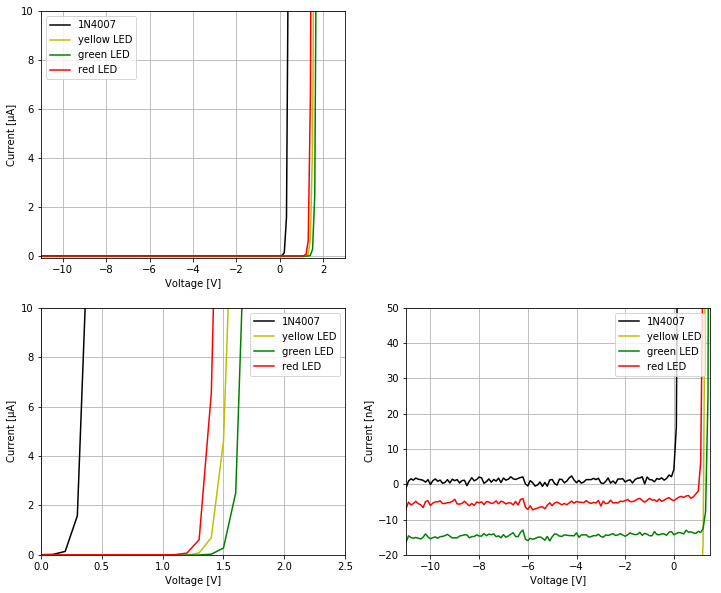

In [21]:
plt.figure(figsize=[12,10])

plt.subplot(2,2,1)

plt.plot(meas_fv[:,0], 1e6*meas_fv[:,1], 'k')
plt.plot(meas_fv[:,2], 1e6*meas_fv[:,3], 'y')
plt.plot(meas_fv[:,4], 1e6*meas_fv[:,5], 'g')
plt.plot(meas_fv[:,6], 1e6*meas_fv[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [µA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([-11, 3, -0.1, 10])
plt.grid(True)


plt.subplot(2,2,3)

plt.plot(meas_fv[:,0], 1e6*meas_fv[:,1], 'k')
plt.plot(meas_fv[:,2], 1e6*meas_fv[:,3], 'y')
plt.plot(meas_fv[:,4], 1e6*meas_fv[:,5], 'g')
plt.plot(meas_fv[:,6], 1e6*meas_fv[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [µA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([0, 2.5, -1e-4, 10])
plt.grid(True)


plt.subplot(2,2,4)

plt.plot(meas_fv[:,0], 1e9*meas_fv[:,1], 'k')
plt.plot(meas_fv[:,2], 1e9*meas_fv[:,3], 'y')
plt.plot(meas_fv[:,4], 1e9*meas_fv[:,5], 'g')
plt.plot(meas_fv[:,6], 1e9*meas_fv[:,7], 'r')

plt.xlabel("Voltage [V]")
plt.ylabel("Current [nA]")
plt.legend(("1N4007", "yellow LED", "green LED", "red LED"))
plt.axis([-11, 1.5, -20, 50])
plt.grid(True)

For the forced voltage measurement we provided the same three plots. The maximum current in the plots is reduced from 22mA to 10µA to increase more accurate measurement of small currents.  
For the positive voltage range one can see that the plot is less smooth than for the forced current measurement. This is because small changes in voltage give high changes in current when above the threshold voltage. The reduced current range also influences the percieved threshold voltage for the different devices.  
For the negative voltage range on the contrary one can now see that one gets current measurements for the full voltage range. One can see that for the 1N4007 diode the current immediately starts to increae when the voltage goes above 0V and not for the LEDs. The measurement now more clearly indicates the need for offset calibration and that the LEDs seems to be able to withstand the out of spec reverse voltage gracefully.  

# Measurement strategy
Combining the two measurements one can see that a more ideal measurement strategy for a diode would be to use forced current measurement for positive voltage to get an accurate smooth curve and forced voltage for the negative voltage range.  
In general using a SMU to measure certain devices gets best results when using opitimized measurement procedures for the specific device one wants to measure.

# Playground

In [22]:
# meas_fv_covered = meas_fv
# meas_fv_uncovered = meas_fv

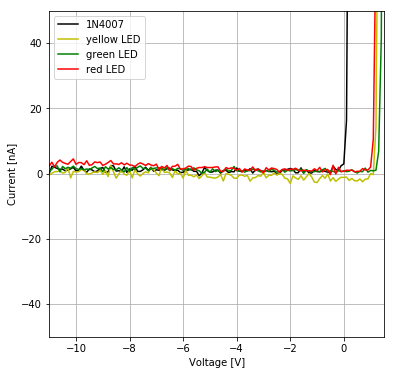

In [29]:
def save_fig(m, name):
    fig = plt.figure(figsize=(6,6))

    plt.plot(m[:,0], 1e9*m[:,1], 'k')
    plt.plot(m[:,2], 1e9*m[:,3], 'y')
    plt.plot(m[:,4], 1e9*m[:,5], 'g')
    plt.plot(m[:,6], 1e9*m[:,7], 'r')

    plt.xlabel("Voltage [V]")
    plt.ylabel("Current [nA]")
    plt.legend(("1N4007", "yellow LED", "green LED", "red LED"), loc="upper left")
    plt.axis([-11, 1.5, -50, 50])
    plt.grid(True)
    
    plt.savefig(name)
save_fig(meas_fv_uncovered, "Diodes_uncovered.png")
save_fig(meas_fv_covered, "Diodes_covered.png")